# 2D prediction for one hole Kevitsa

In [1]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import numpy as np 
import pandas as pd 
from scipy import linalg
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

from sklearn.model_selection import KFold
np.random.seed(2147483648)


In [2]:
two_composite_filtered = pd.read_csv("Curated_data/two_composite_filtered.csv", low_memory=False)


C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\1197910786.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hole_data[column] = hole_data[column] - min_values[column]
C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\1197910786.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hole_data[column] = (hole_data[column] - min_values) / (max_values - min_values)
C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\1197910786.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

- Iteration 0, MSE: 0.2045
- Iteration 100, MSE: 0.0098
- Iteration 200, MSE: 0.0070
- Iteration 300, MSE: 0.0063
- Iteration 400, MSE: 0.0060
- Iteration 500, MSE: 0.0058
- Iteration 600, MSE: 0.0056
- Iteration 700, MSE: 0.0055
- Iteration 800, MSE: 0.0055
- Iteration 900, MSE: 0.0054
- Iteration 1000, MSE: 0.0054
- Iteration 1100, MSE: 0.0054
- Iteration 1200, MSE: 0.0054
- Iteration 1300, MSE: 0.0054
- Iteration 1400, MSE: 0.0054
- Iteration 1500, MSE: 0.0054
- Iteration 1600, MSE: 0.0054
- Iteration 1700, MSE: 0.0054
- Iteration 1800, MSE: 0.0054
- Iteration 1900, MSE: 0.0054
- Iteration 2000, MSE: 0.0054
- Iteration 2100, MSE: 0.0054
- Iteration 2200, MSE: 0.0054
- Iteration 2300, MSE: 0.0054
- Iteration 2400, MSE: 0.0054
- Iteration 2500, MSE: 0.0054
- Iteration 2600, MSE: 0.0054
- Iteration 2700, MSE: 0.0054
- Iteration 2800, MSE: 0.0054
- Iteration 2900, MSE: 0.0054
- Iteration 3000, MSE: 0.0054
- Iteration 3100, MSE: 0.0054
- Iteration 3200, MSE: 0.0054
- Iteration 3300, MSE:

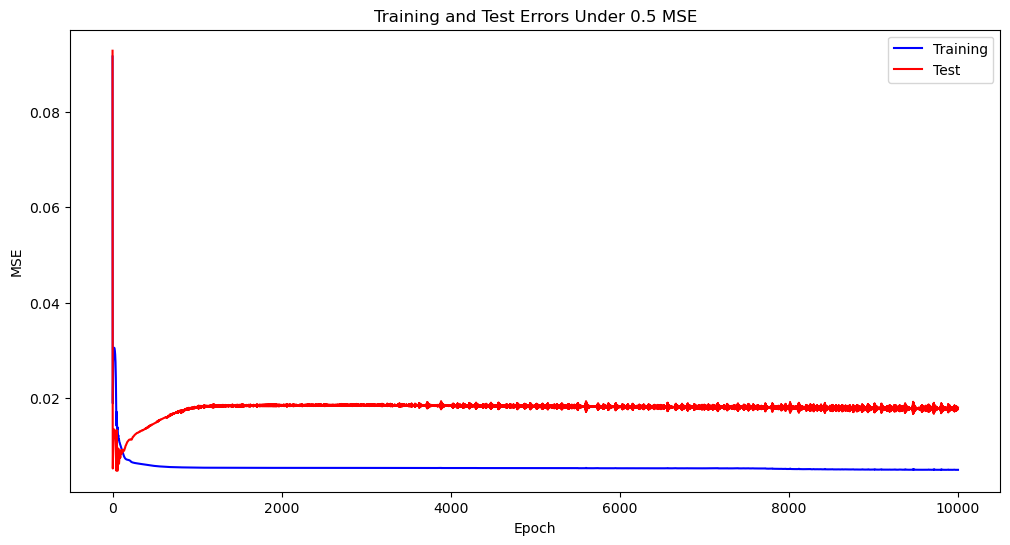

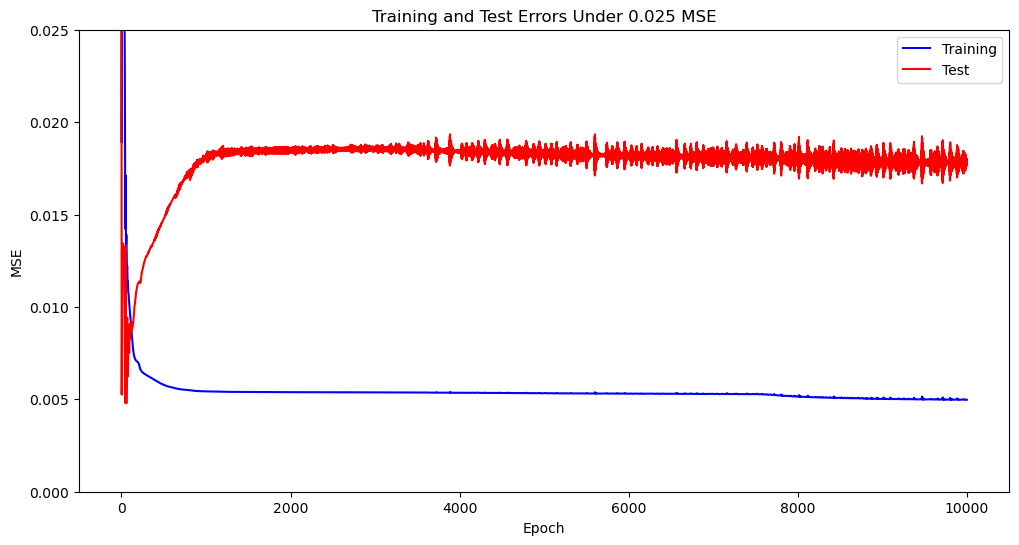

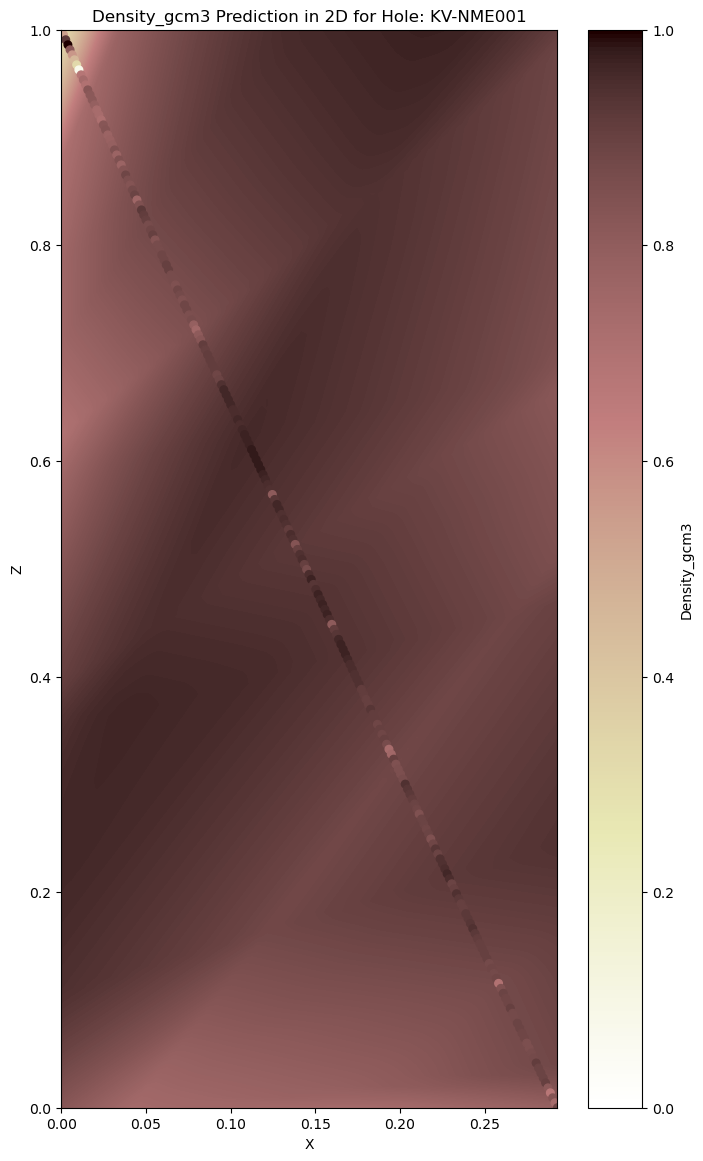

In [3]:
#Subset data for each mineral
mineral = 'Density_gcm3'
two_composite_filtered = two_composite_filtered.loc[:,["Name", 'X', 'Y', 'Z', mineral]]
two_composite_1mineral = two_composite_filtered.dropna(subset=[mineral])

np.random.seed(2147483648)

# Define the specific hole you want to predict for
hole_name = 'KV-NME001'


# Filter the data for the selected hole
hole_data = two_composite_1mineral[two_composite_1mineral['Name'] == hole_name]

# Define the columns to normalize
columns_to_normalize = ['X', 'Y', 'Z']  # Add all columns you want to normalize

min_values = hole_data[columns_to_normalize].min()

for column in columns_to_normalize:
    hole_data[column] = hole_data[column] - min_values[column]

# Calculate the minimum and maximum values from the entire dataset
min_values = hole_data[columns_to_normalize].min().min()
max_values = hole_data[columns_to_normalize].max().max()

# Scale the data to (0, 1) using the calculated minimum and maximum values
for column in columns_to_normalize:
    hole_data[column] = (hole_data[column] - min_values) / (max_values - min_values)


# Create a MinMaxScaler instance
scaler = MinMaxScaler()


# Fit the scaler to your data and transform the specified columns
hole_data.loc[:, [mineral]] = scaler.fit_transform(hole_data.loc[:, [mineral]])



# Extract the features (X and Y coordinates) and target (mineral) for the selected hole
x = hole_data[['X', 'Z']].values#[:,np.newaxis] makes the second dimension explicit
y = hole_data[mineral].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit

x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)

# Determine the size of the test set (e.g., 20% of the data)
test_size = int(0.2 * len(x))

# Generate random indices for the test set
test_indices = np.random.choice(len(x), size=test_size, replace=False)

# Create train and test sets based on the indices
x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]

x_test = x[np.sort(test_indices)]
y_test = y[np.sort(test_indices)]




# Split the data into train and test sets
test_size = int(0.2 * len(x))
test_indices = np.random.choice(len(x), size=test_size, replace=False)
x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]
x_test = x[np.sort(test_indices)]
y_test = y[np.sort(test_indices)]

model = nn.Sequential(
    nn.Linear(in_features=2, out_features=300),
    nn.ReLU(),
    nn.Linear(in_features=300, out_features=1),
    nn.Sigmoid(),
)

mse_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_losses = []  # To store training losses during training
test_losses = []   # To store test losses during training

for step in range(10000):
    pre = model(x_train)
    mse = mse_loss(pre, y_train)
    cost = mse

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    pre_train = model(x_train)
    mse_train = mse_loss(pre_train, y_train)
    train_losses.append(mse_train.item())

    # Evaluate the model on the test set
    pre_test = model(x_test)
    mse_test = mse_loss(pre_test, y_test)
    test_losses.append(mse_test.item())

    if step % 100 == 0:
        print(f'- Iteration {step}, MSE: {mse.item():.4f}')


# Create a plot showing only values under 0.2 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
#plt.ylim(0, 0.5)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.5 MSE')
plt.show()



# Create a plot showing only values under 0.05 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.025)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.025 MSE')
plt.show()




# Define a grid of points for prediction
x_grid_hole = np.linspace(x[:, 0].min(), x[:, 0].max(), 100)
y_grid_hole = np.linspace(x[:, 1].min(), x[:, 1].max(), 100)
xv_hole, yv_hole = np.meshgrid(x_grid_hole, y_grid_hole)
xy_grid_hole = np.c_[xv_hole.ravel(), yv_hole.ravel()]

# Make predictions for the grid
predictions_hole = model(torch.tensor(xy_grid_hole, dtype=torch.float32))

# Reshape the predictions to match the grid shape
predictions_hole = predictions_hole.data.numpy().reshape(xv_hole.shape)



# Pool the values from predictions_hole and y_hole
pooled_values = np.concatenate([predictions_hole.ravel(), y.data.numpy()[:, 0]])

# Determine the minimum and maximum values for the color mapping
vmin = np.min(pooled_values)
vmax = np.max(pooled_values)

# Create a ScalarMappable for both plots using the same criteria
sm = ScalarMappable(cmap='pink_r')
sm.set_array([])  # Set an empty array to enforce the same vmin and vmax
sm.set_clim(vmin, vmax)  # Set the same vmin and vmax

plt.figure(figsize=(8, 14))

contour_hole = plt.contourf(xv_hole, yv_hole, predictions_hole, cmap='pink_r', vmin=vmin, vmax=vmax, levels=500)  # Adjust levels as needed
scatter = plt.scatter(x.data.numpy()[:, 0], x.data.numpy()[:, 1], c=y.data.numpy(), cmap='pink_r', vmin=vmin, vmax=vmax, s=30, label='Selected Hole Data')

# Optionally, you can scatter plot the data points for this specific hole

# Add a colorbar associated with both plots
ax = plt.gca()
cb = plt.colorbar(sm, label=mineral, ax=ax)
# Set the color mapping based on the scatter plot

plt.xlabel('X')
plt.ylabel('Z')
plt.title(f'{mineral} Prediction in 2D for Hole: {hole_name}')
plt.show()


## All Holes

C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hole_data.loc[:, column] = hole_data[column] - min_values[column]
C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hole_data[column] = (hole_data[column] - min_values) / (max_values - min_values)
C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:35: SettingWithCopyWarning: 
A value is trying to be set on a co

- Iteration 0, MSE: 0.999
- Iteration 1000, MSE: 0.008
- Iteration 2000, MSE: 0.007
- Iteration 3000, MSE: 0.007
- Iteration 4000, MSE: 0.007


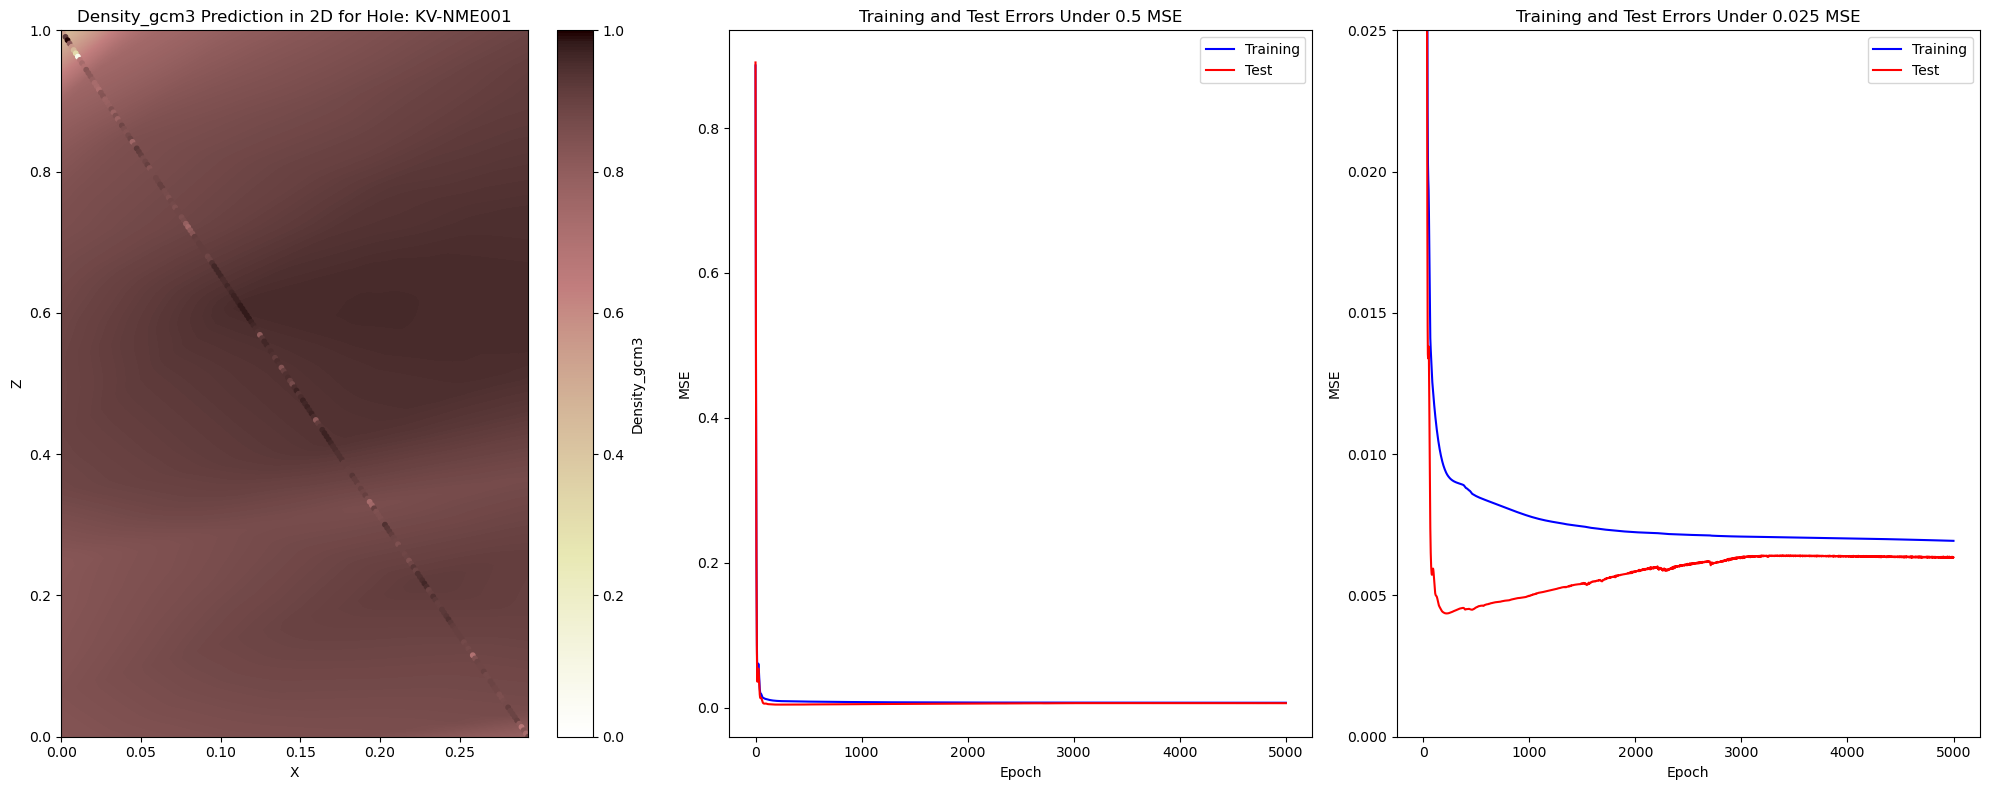

C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hole_data.loc[:, column] = hole_data[column] - min_values[column]
C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hole_data[column] = (hole_data[column] - min_values) / (max_values - min_values)
C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:35: SettingWithCopyWarning: 
A value is trying to be set on a co

- Iteration 0, MSE: 0.151
- Iteration 1000, MSE: 0.013
- Iteration 2000, MSE: 0.012
- Iteration 3000, MSE: 0.011
- Iteration 4000, MSE: 0.011


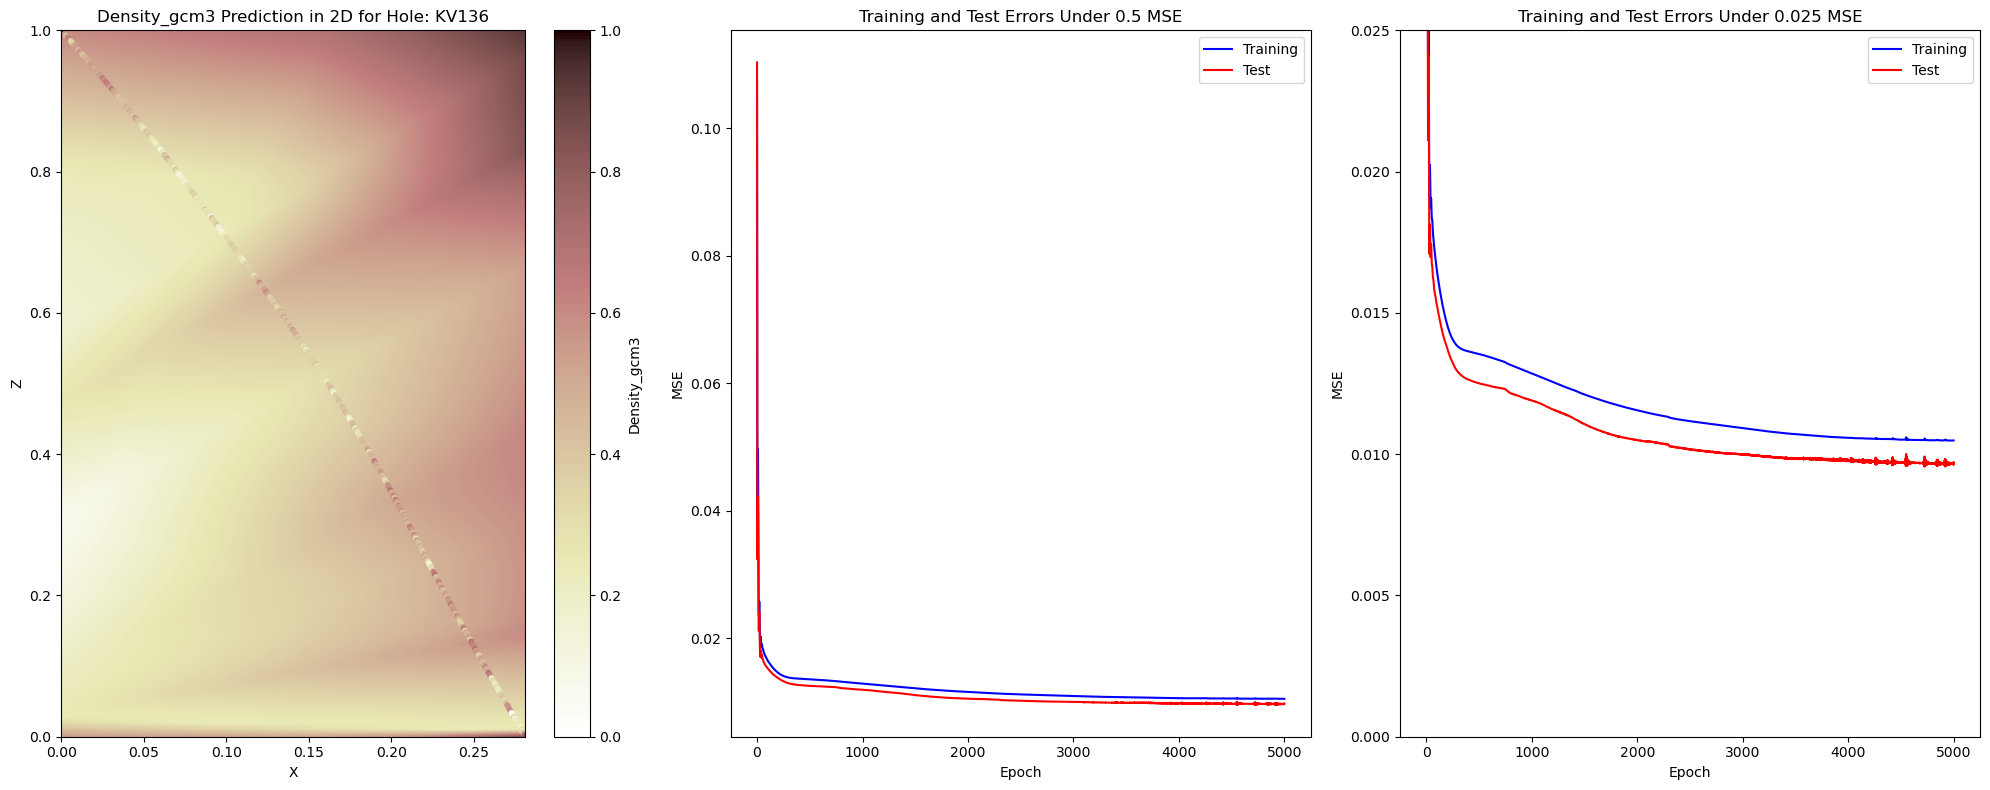

C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hole_data.loc[:, column] = hole_data[column] - min_values[column]
C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hole_data[column] = (hole_data[column] - min_values) / (max_values - min_values)
C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:35: SettingWithCopyWarning: 
A value is trying to be set on a co

- Iteration 0, MSE: 0.854
- Iteration 1000, MSE: 0.020
- Iteration 2000, MSE: 0.020
- Iteration 3000, MSE: 0.019
- Iteration 4000, MSE: 0.019


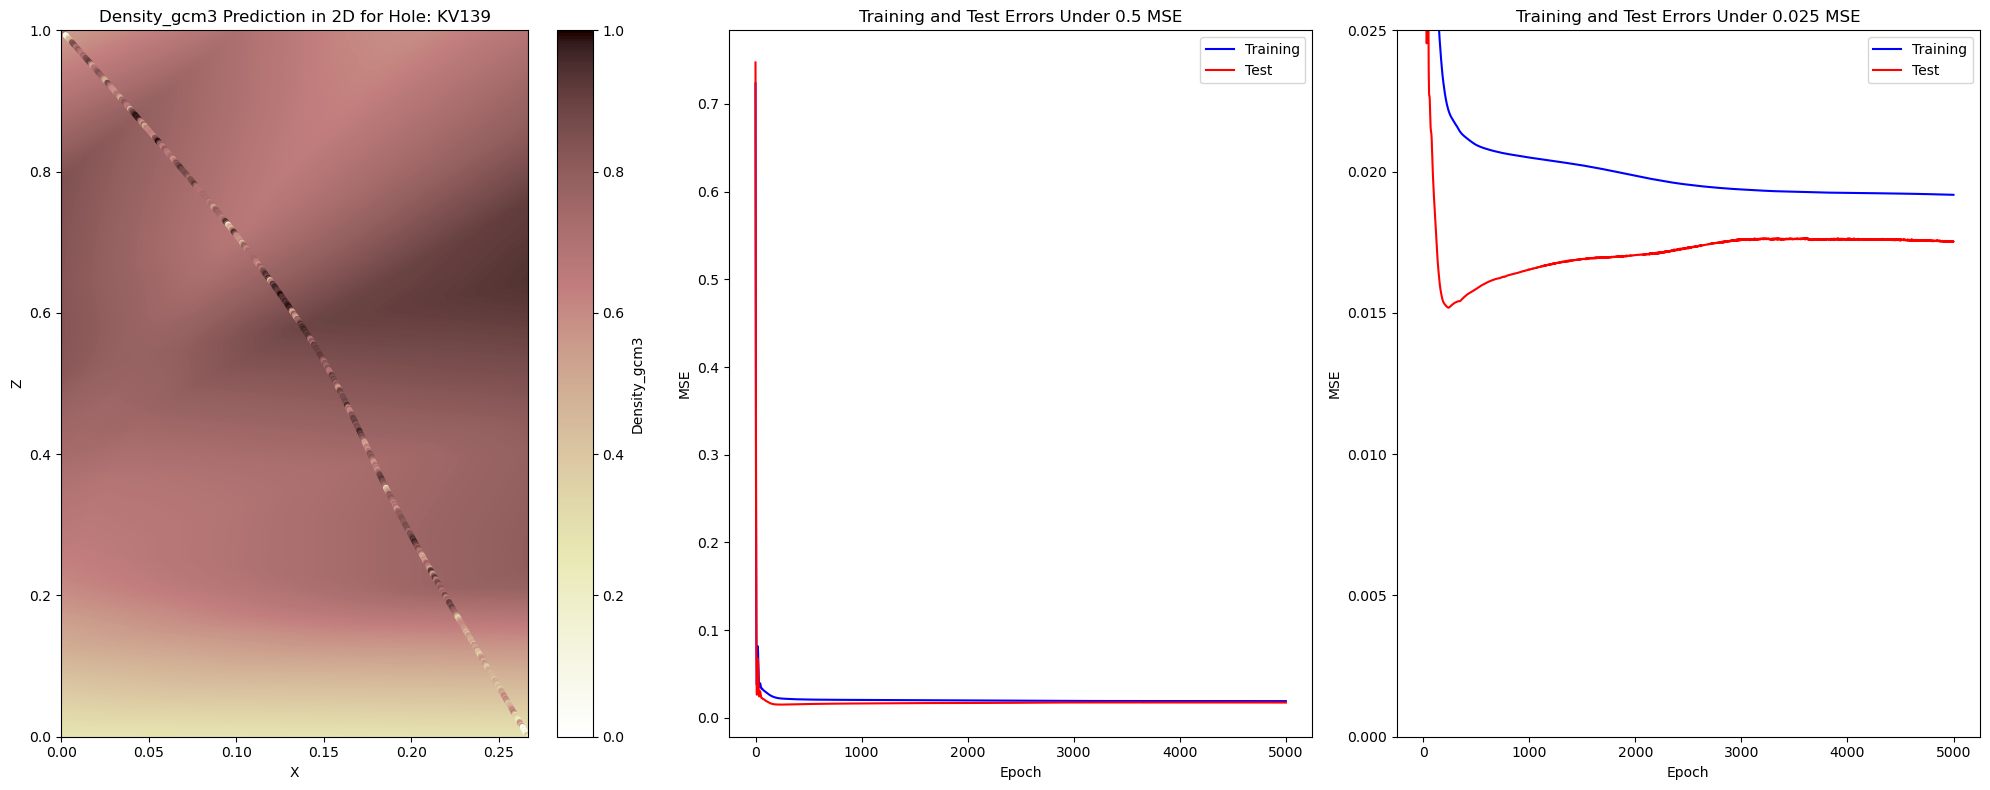

C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hole_data.loc[:, column] = hole_data[column] - min_values[column]
C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hole_data[column] = (hole_data[column] - min_values) / (max_values - min_values)
C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:35: SettingWithCopyWarning: 
A value is trying to be set on a co

- Iteration 0, MSE: 0.188
- Iteration 1000, MSE: 0.010
- Iteration 2000, MSE: 0.010
- Iteration 3000, MSE: 0.010
- Iteration 4000, MSE: 0.010


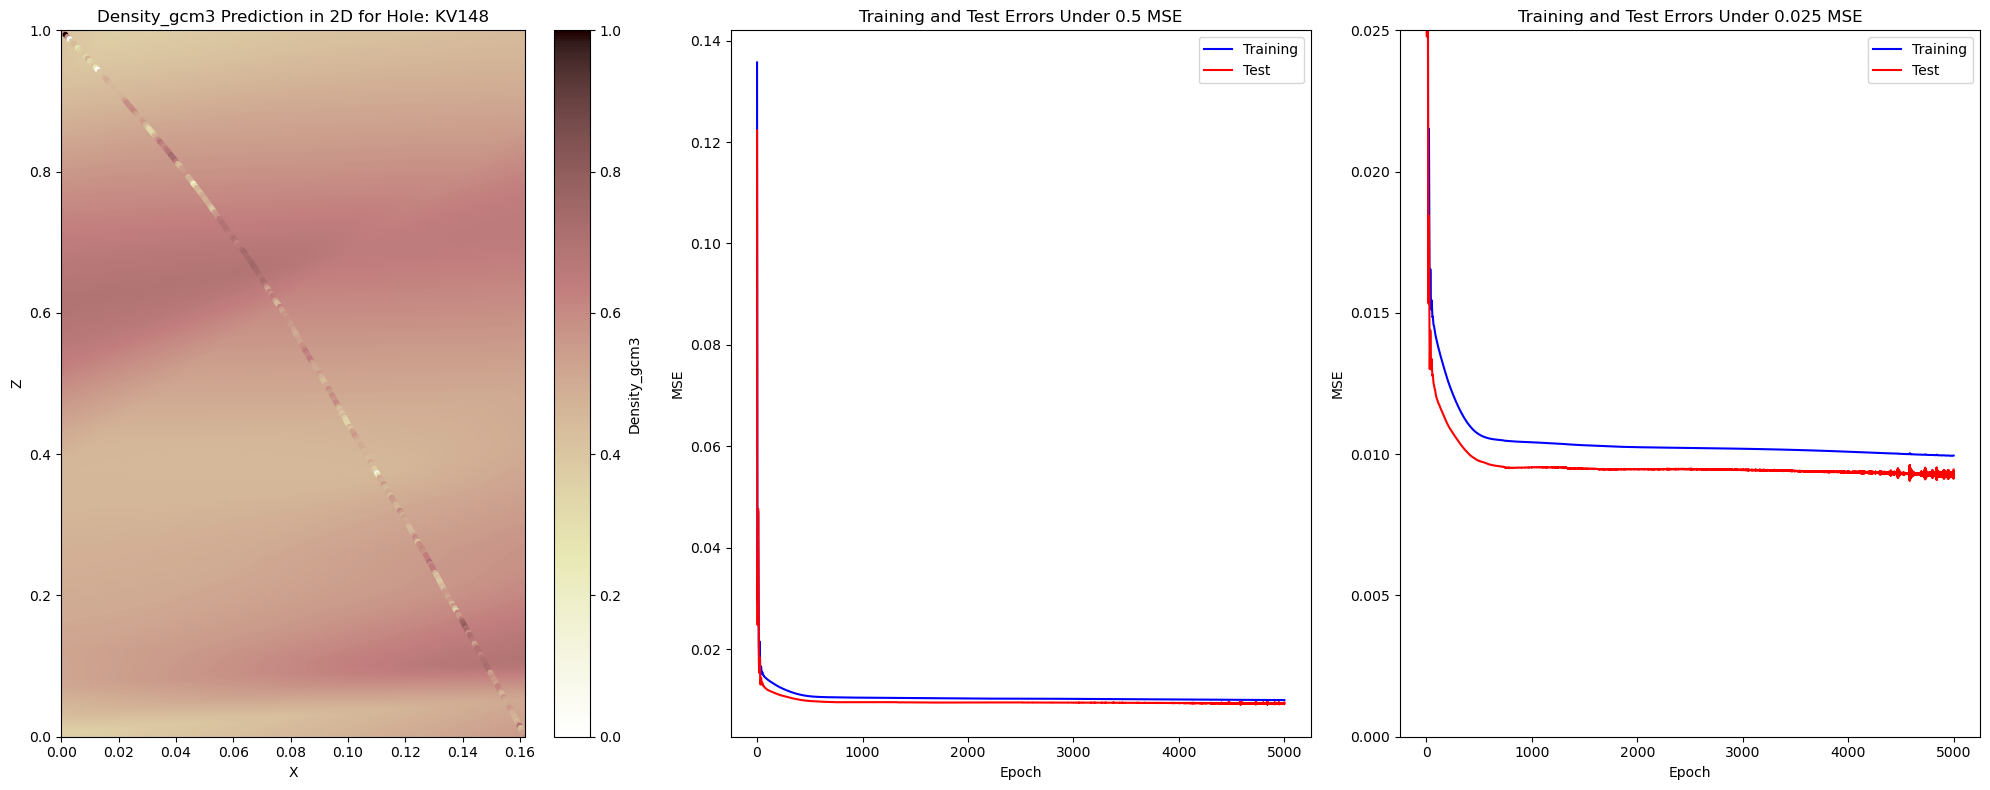

C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hole_data.loc[:, column] = hole_data[column] - min_values[column]
C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hole_data[column] = (hole_data[column] - min_values) / (max_values - min_values)
C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:35: SettingWithCopyWarning: 
A value is trying to be set on a co

- Iteration 0, MSE: 0.622
- Iteration 1000, MSE: 0.018
- Iteration 2000, MSE: 0.014
- Iteration 3000, MSE: 0.013
- Iteration 4000, MSE: 0.013


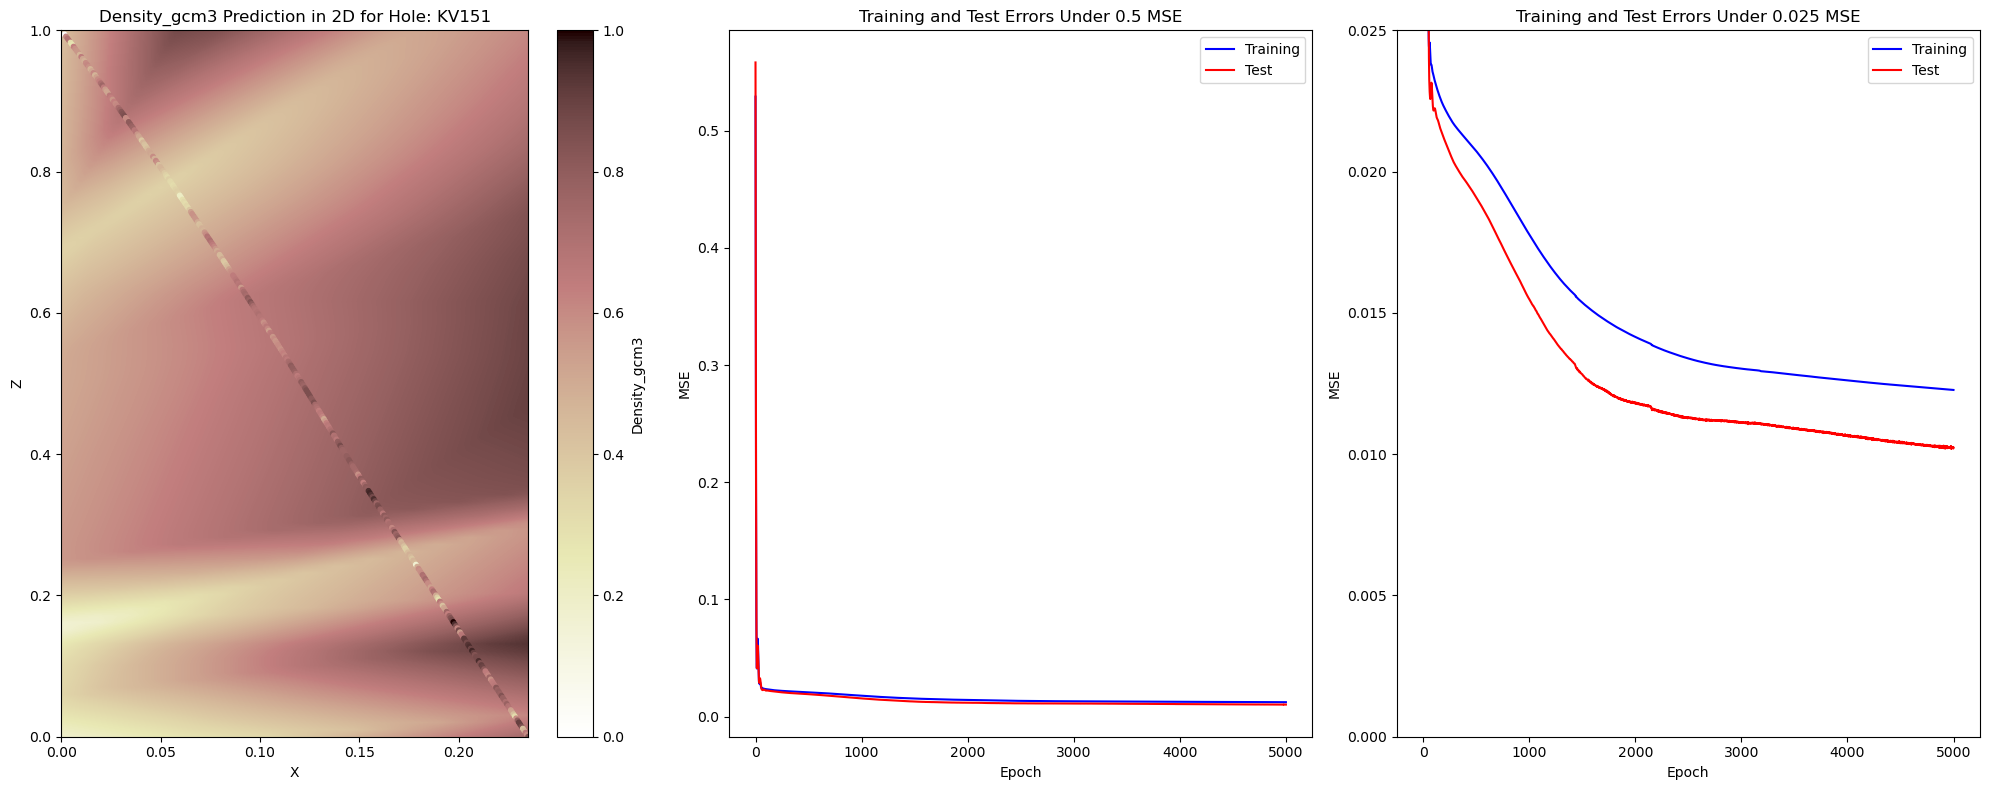

C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hole_data.loc[:, column] = hole_data[column] - min_values[column]
C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hole_data[column] = (hole_data[column] - min_values) / (max_values - min_values)
C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:35: SettingWithCopyWarning: 
A value is trying to be set on a co

- Iteration 0, MSE: 0.105
- Iteration 1000, MSE: 0.010
- Iteration 2000, MSE: 0.009
- Iteration 3000, MSE: 0.009
- Iteration 4000, MSE: 0.008


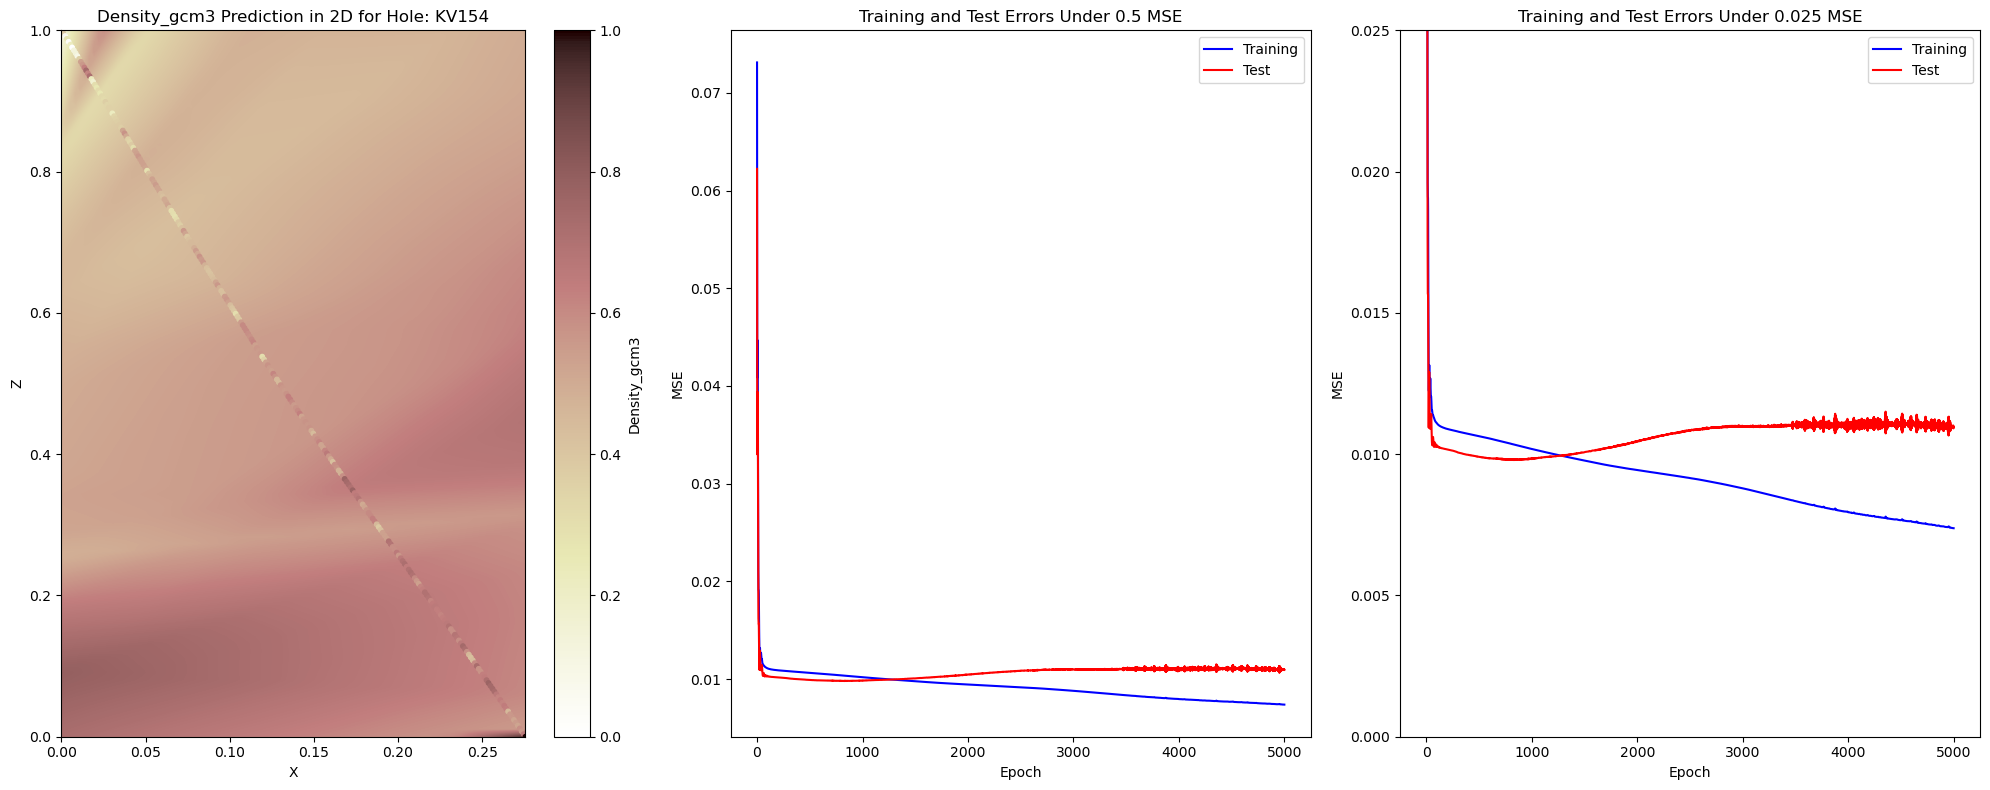

C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hole_data.loc[:, column] = hole_data[column] - min_values[column]
C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hole_data[column] = (hole_data[column] - min_values) / (max_values - min_values)
C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:35: SettingWithCopyWarning: 
A value is trying to be set on a co

- Iteration 0, MSE: 0.467
- Iteration 1000, MSE: 0.005
- Iteration 2000, MSE: 0.005
- Iteration 3000, MSE: 0.005
- Iteration 4000, MSE: 0.004


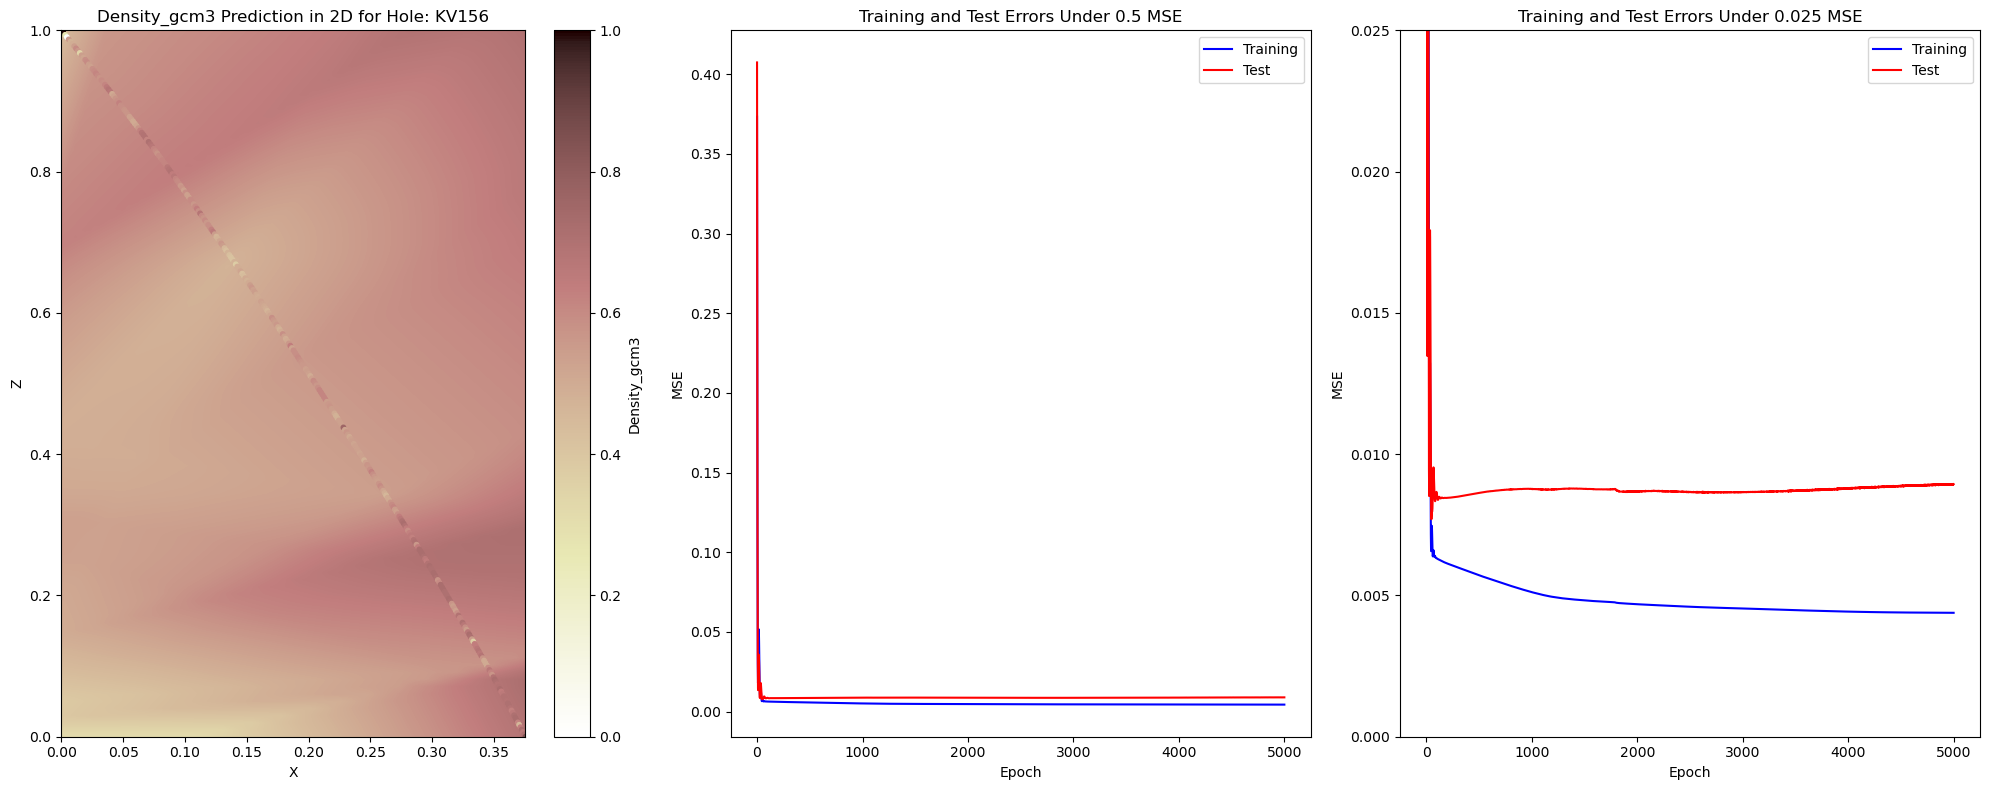

C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hole_data.loc[:, column] = hole_data[column] - min_values[column]
C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hole_data[column] = (hole_data[column] - min_values) / (max_values - min_values)
C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:35: SettingWithCopyWarning: 
A value is trying to be set on a co

- Iteration 0, MSE: 0.060
- Iteration 1000, MSE: 0.009
- Iteration 2000, MSE: 0.008
- Iteration 3000, MSE: 0.008
- Iteration 4000, MSE: 0.008


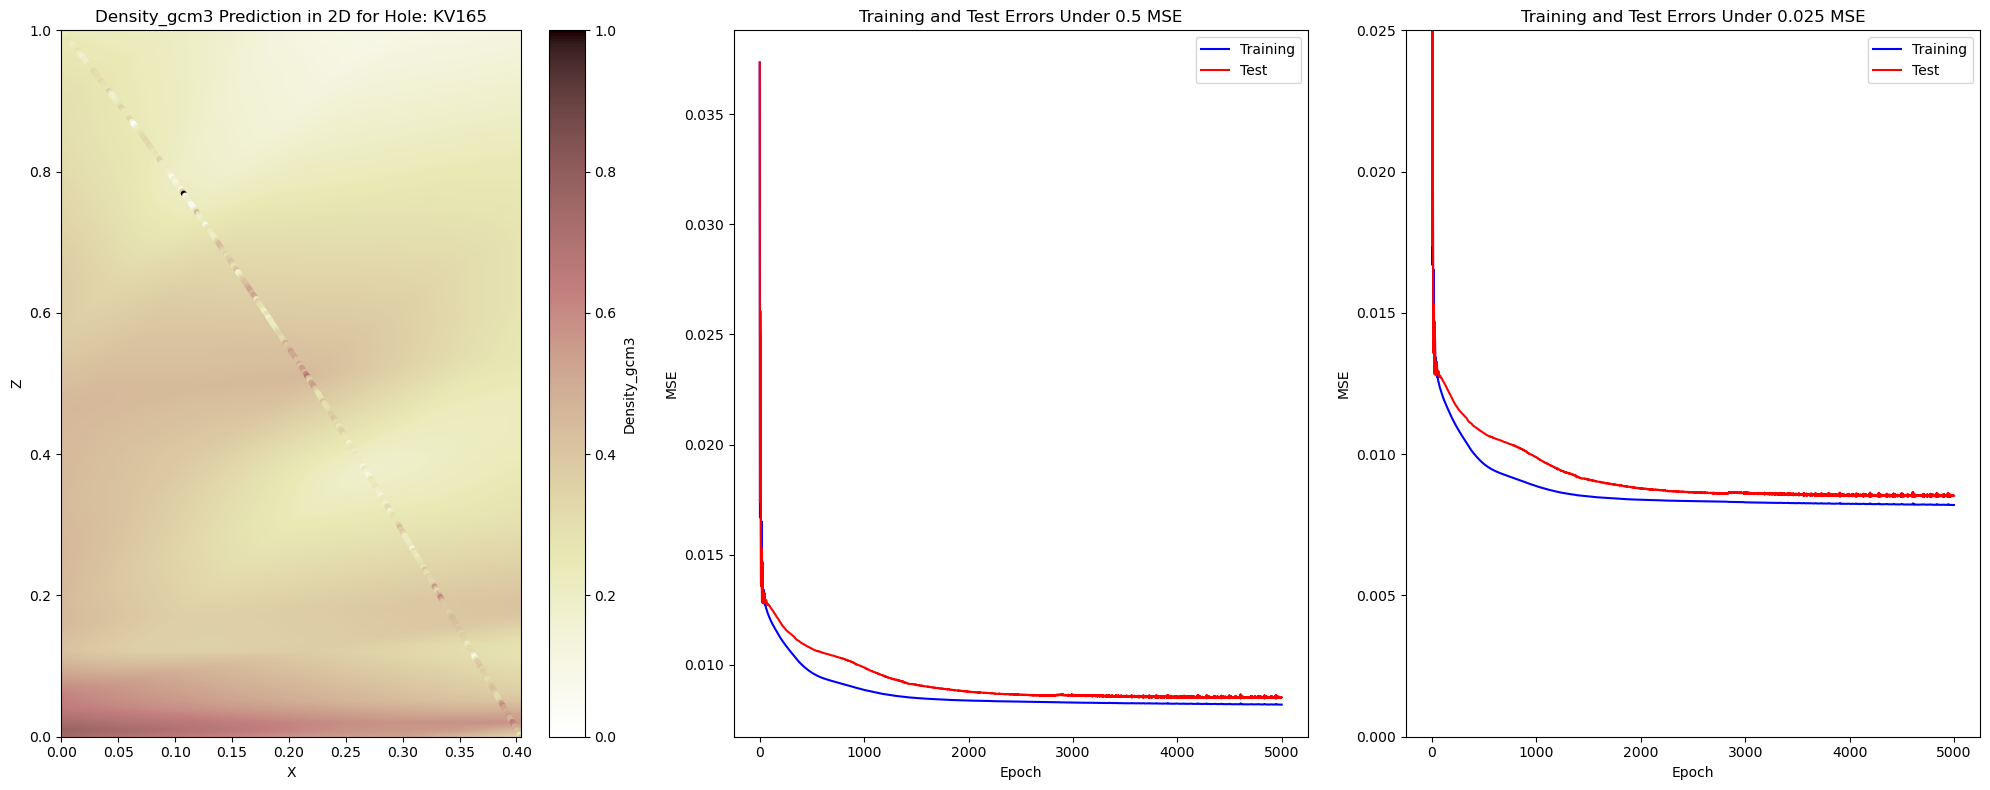

C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hole_data.loc[:, column] = hole_data[column] - min_values[column]
C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hole_data[column] = (hole_data[column] - min_values) / (max_values - min_values)
C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:35: SettingWithCopyWarning: 
A value is trying to be set on a co

- Iteration 0, MSE: 0.074
- Iteration 1000, MSE: 0.010
- Iteration 2000, MSE: 0.008
- Iteration 3000, MSE: 0.008
- Iteration 4000, MSE: 0.007


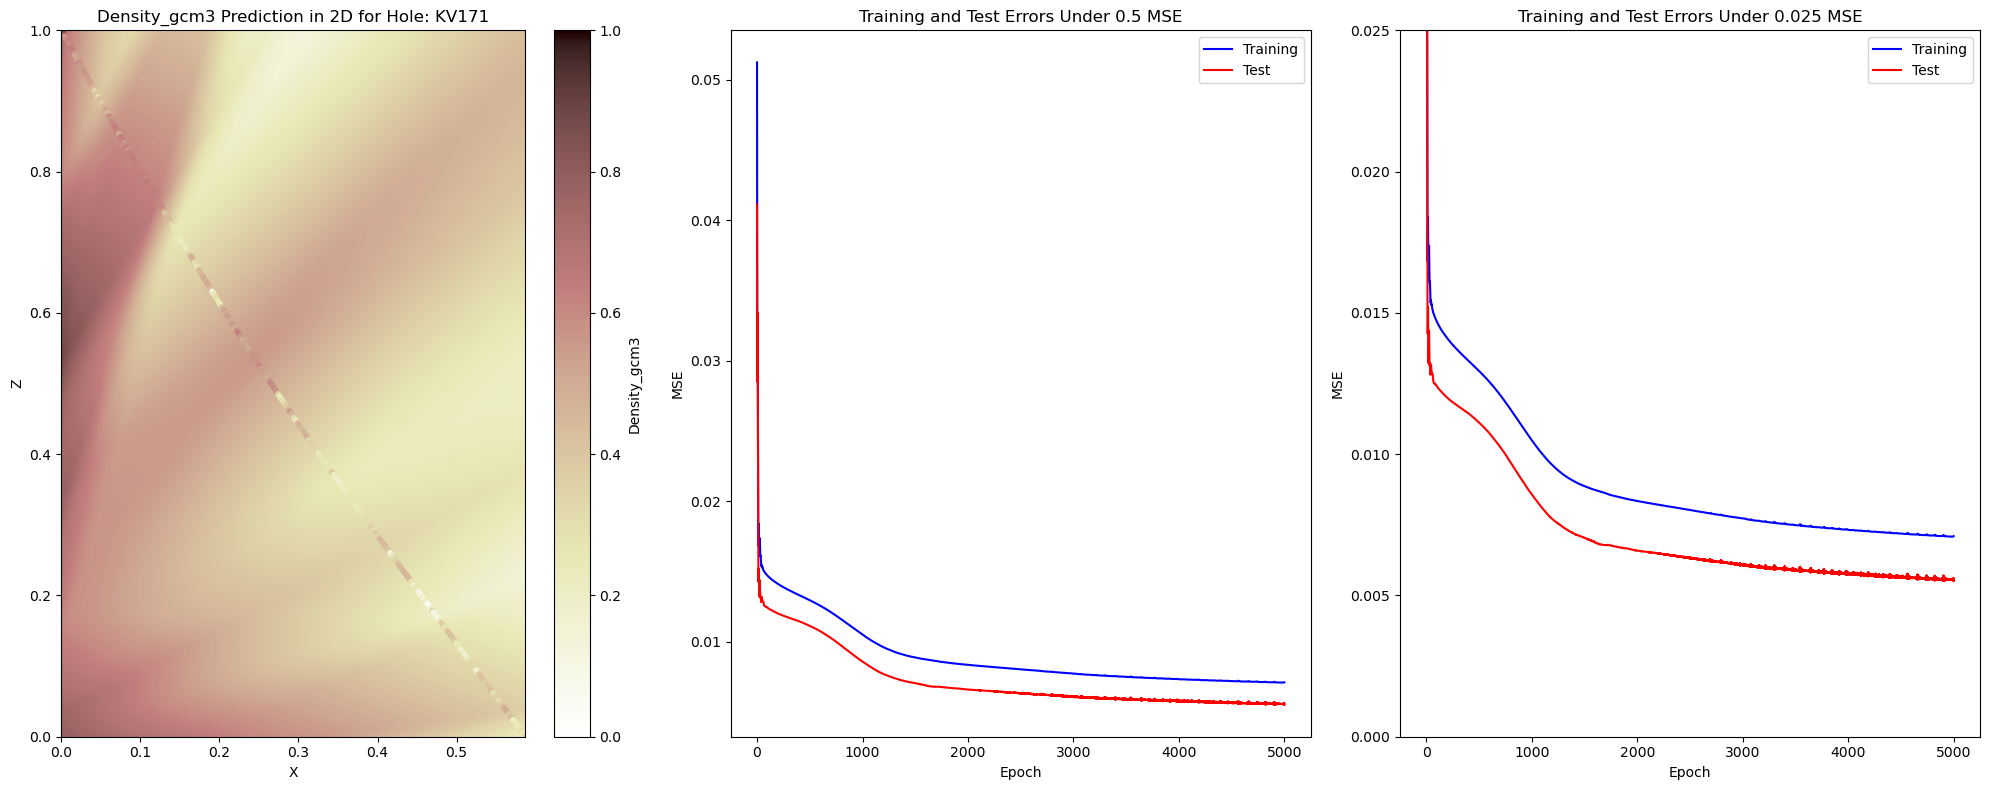

C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hole_data.loc[:, column] = hole_data[column] - min_values[column]
C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hole_data[column] = (hole_data[column] - min_values) / (max_values - min_values)
C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:35: SettingWithCopyWarning: 
A value is trying to be set on a co

- Iteration 0, MSE: 0.423
- Iteration 1000, MSE: 0.017
- Iteration 2000, MSE: 0.014
- Iteration 3000, MSE: 0.012
- Iteration 4000, MSE: 0.012


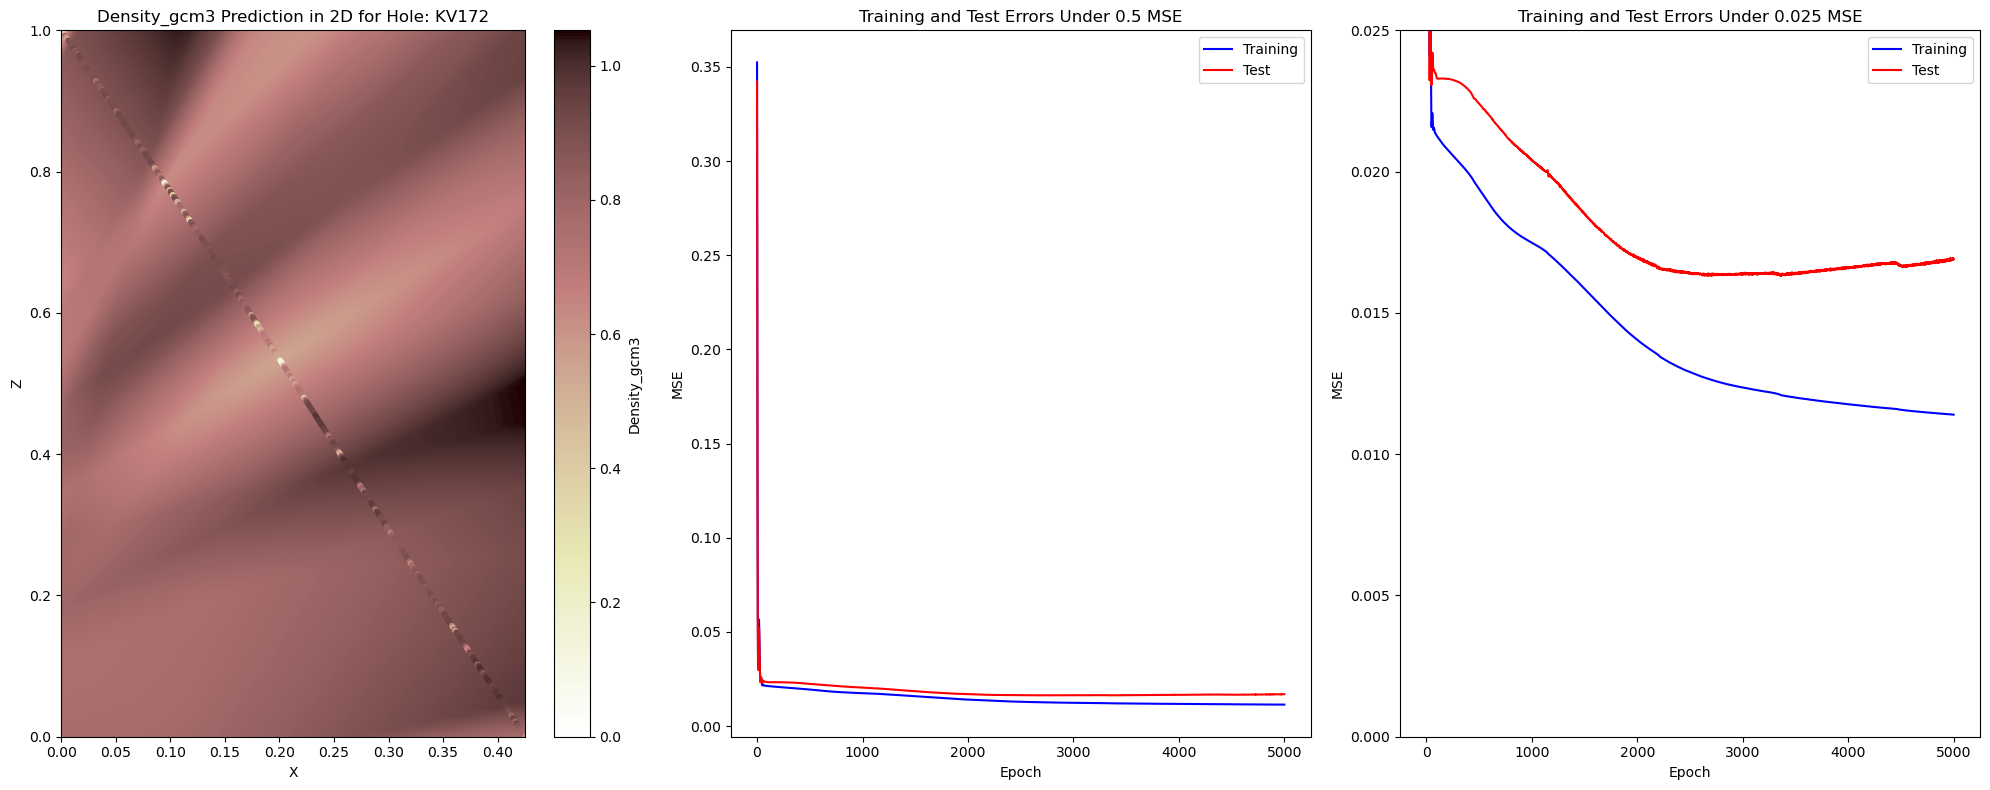

C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hole_data.loc[:, column] = hole_data[column] - min_values[column]
C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hole_data[column] = (hole_data[column] - min_values) / (max_values - min_values)
C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:35: SettingWithCopyWarning: 
A value is trying to be set on a co

- Iteration 0, MSE: 0.518
- Iteration 1000, MSE: 0.016
- Iteration 2000, MSE: 0.015
- Iteration 3000, MSE: 0.015
- Iteration 4000, MSE: 0.013


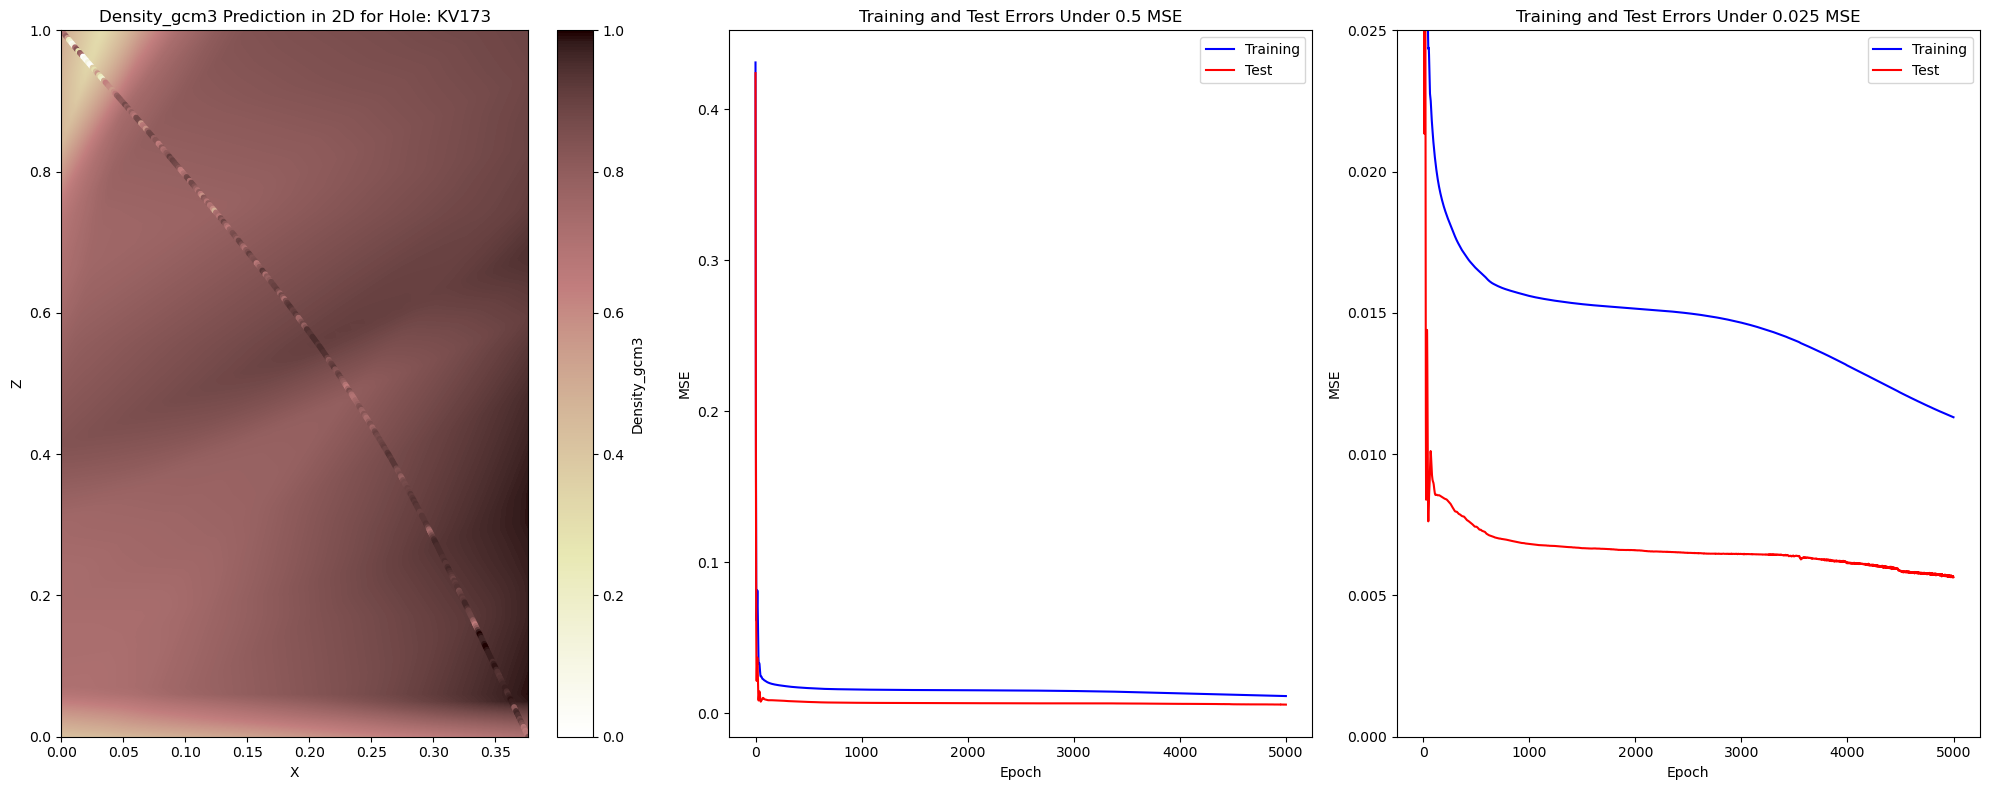

C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hole_data.loc[:, column] = hole_data[column] - min_values[column]
C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hole_data[column] = (hole_data[column] - min_values) / (max_values - min_values)
C:\Users\23478671\AppData\Local\Temp\ipykernel_16532\3834383099.py:35: SettingWithCopyWarning: 
A value is trying to be set on a co

- Iteration 0, MSE: 1.035
- Iteration 1000, MSE: 0.004
- Iteration 2000, MSE: 0.004
- Iteration 3000, MSE: 0.004


KeyboardInterrupt: 

In [4]:
mineral = 'Density_gcm3'
two_composite_filtered = two_composite_filtered.loc[:,["Name", 'X', 'Y', 'Z', mineral]]
two_composite_1mineral = two_composite_filtered.dropna(subset=[mineral])
for hole_name in two_composite_filtered['Name'].unique():
    
    # Define the specific hole you want to predict for

    # Filter the data for the selected hole
    hole_data = two_composite_1mineral.loc[two_composite_1mineral['Name'] == hole_name]
    if len(hole_data) < 100:
        continue
    
    # Define the columns to normalize
    columns_to_normalize = ['X', 'Y', 'Z']  # Add all columns you want to normalize

    min_values = hole_data[columns_to_normalize].min()

    for column in columns_to_normalize:
        hole_data.loc[:, column] = hole_data[column] - min_values[column]

    # Calculate the minimum and maximum values from the entire dataset
    min_values = hole_data[columns_to_normalize].min().min()
    max_values = hole_data[columns_to_normalize].max().max()

    # Scale the data to (0, 1) using the calculated minimum and maximum values
    for column in columns_to_normalize:
        hole_data[column] = (hole_data[column] - min_values) / (max_values - min_values)


    # Create a MinMaxScaler instance
    scaler = MinMaxScaler()


    # Fit the scaler to your data and transform the specified columns
    hole_data.loc[:, [mineral]] = scaler.fit_transform(hole_data.loc[:, [mineral]])

    # Extract the features (X and Y coordinates) and target (mineral) for the selected hole
    x = hole_data[['X', 'Z']].values#[:,np.newaxis] makes the second dimension explicit
    y = hole_data[mineral].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit


    # Create train and test sets
    x = torch.tensor(x)
    y = torch.tensor(y)
    x = x.to(torch.float32)
    y = y.to(torch.float32)

    # Split the data into train and test sets
    test_size = int(0.2 * len(x))
    test_indices = np.random.choice(len(x), size=test_size, replace=False)
    x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
    y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]
    x_test = x[np.sort(test_indices)]
    y_test = y[np.sort(test_indices)]

    model = nn.Sequential(
        nn.Linear(in_features=2, out_features=300),
        nn.ReLU(),
        nn.Linear(in_features=300, out_features=1)
    )

    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []  # To store training losses during training
    test_losses = []   # To store test losses during training

    for step in range(5000):
        pre = model(x_train)
        mse = mse_loss(pre, y_train)
        cost = mse

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        pre_train = model(x_train)
        mse_train = mse_loss(pre_train, y_train)
        train_losses.append(mse_train.item())

        # Evaluate the model on the test set
        pre_test = model(x_test)
        mse_test = mse_loss(pre_test, y_test)
        test_losses.append(mse_test.item())

        if step % 1000 == 0:
            print(f'- Iteration {step}, MSE: {mse.item():.3f}')






    # Define a grid of points for prediction
    x_grid_hole = np.linspace(x[:, 0].min(), x[:, 0].max(), 100)
    y_grid_hole = np.linspace(x[:, 1].min(), x[:, 1].max(), 100)
    xv_hole, yv_hole = np.meshgrid(x_grid_hole, y_grid_hole)
    xy_grid_hole = np.c_[xv_hole.ravel(), yv_hole.ravel()]

    # Make predictions for the grid
    predictions_hole = model(torch.tensor(xy_grid_hole, dtype=torch.float32))

    # Reshape the predictions to match the grid shape
    predictions_hole = predictions_hole.data.numpy().reshape(xv_hole.shape)



    # Pool the values from predictions_hole and y_hole
    pooled_values = np.concatenate([predictions_hole.ravel(), y.data.numpy()[:, 0]])

    # Determine the minimum and maximum values for the color mapping
    vmin = np.min(pooled_values)
    vmax = np.max(pooled_values)

    # Create a ScalarMappable for both plots using the same criteria
    sm = ScalarMappable(cmap='pink_r')
    sm.set_array([])  # Set an empty array to enforce the same vmin and vmax
    sm.set_clim(vmin, vmax)  # Set the same vmin and vmax







    # Create a scatter plot on the left
    plt.figure(figsize=(20, 8))
    plt.subplot(131)
    contour_hole = plt.contourf(xv_hole, yv_hole, predictions_hole, cmap='pink_r', vmin=vmin, vmax=vmax, levels=500)  # Adjust levels as needed
    scatter = plt.scatter(x.data.numpy()[:, 0], x.data.numpy()[:, 1], c=y.data.numpy(), cmap='pink_r', vmin=vmin, vmax=vmax, s=10, label='Selected Hole Data')

    # Optionally, you can scatter plot the data points for this specific hole

    # Add a colorbar associated with both plots
    ax = plt.gca()
    cb = plt.colorbar(sm, label=mineral, ax=ax)
    # Set the color mapping based on the scatter plot

    plt.xlabel('X')
    plt.ylabel('Z')
    plt.title(f'{mineral} Prediction in 2D for Hole: {hole_name}')


    # Create a layout for the two error plots on the right
    plt.subplot(132)
    # Create a plot showing only values under 0.2 on the y-axis
    plt.plot(train_losses, label='Training', color='blue')
    plt.plot(test_losses, label='Test', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    #plt.ylim(0, 0.5)  # Set the y-axis limit to filter values under 0.05
    plt.legend()
    plt.title('Training and Test Errors')


    plt.subplot(133)
    plt.plot(train_losses, label='Training', color='blue')
    plt.plot(test_losses, label='Test', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.ylim(0, 0.025)  # Set the y-axis limit to filter values under 0.05
    plt.legend()
    plt.title('Training and Test Errors Under 0.025 MSE')

    plt.tight_layout()
    plt.show()